# 02. Neural Network classification with PyTorch

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, 
                    noise = 0.03, 
                    random_state = 42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0], 
                        'X2': X[:, 1], 
                        'label': y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


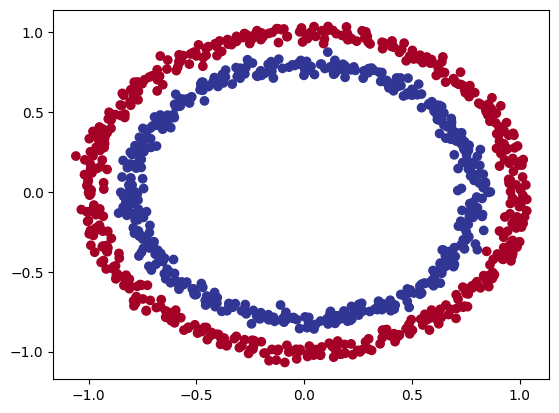

In [6]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0], 
            y = X[:, 1], 
            c = y, 
            cmap = plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
import torch
torch.__version__

'2.0.1+cu118'

In [11]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # 20% of data will be test data and the rest will be train data
                                                    random_state = 42
                                                    )

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

1. Setup device agnostic.
2. Construct a model (by subclassing `nn.Module`).
3. Define a loss functions and optimizer.
4. Create a training and test loop.

In [16]:
import torch
from torch import nn

# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Create a model that:

1. Subclasses `nn.Module`
2. Creates 2 `nn.Linear()` layers that can handle the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (forward computation)
4. Instatiate an instance of our model class and send it to the target device

In [17]:
# Construct the  model
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn.Linear layers
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)  
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  # Define the forward() method
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

# Instatiate an instanche of our model and send it to target device
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
device

'cpu'

In [19]:
next(model_0.parameters()).device

device(type='cpu')

In [20]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2970, -0.0439],
                      [-0.0857,  0.1758],
                      [-0.5274,  0.4830],
                      [ 0.4076,  0.6609],
                      [ 0.6000, -0.6771]])),
             ('0.bias', tensor([ 0.0540,  0.0842, -0.0609,  0.4496,  0.2827])),
             ('1.weight',
              tensor([[-0.4061, -0.0969, -0.2004, -0.1587,  0.3415]])),
             ('1.bias', tensor([-0.2272]))])

In [22]:
# Make predictions
model_0.eval()
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)} | Shape: {untrained_preds.shape}")
print(f"Length of test sample: {len(X_train)} | Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200 | Shape: torch.Size([200, 1])
Length of test sample: 800 | Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.],
        [-1.],
        [-0.],
        [-1.],
        [ 0.],
        [ 0.],
        [-0.],
        [-0.],
        [-0.],
        [-1.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [23]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Loss:

For regression: **MAE** or **MSE** (mean absolute error or mean squared error)

For classification: **binary cross entropy** (BCE) or **categorical cross entropy** (cross entropy)

Optimizer:

* **SGD**
* **Adam**

In [24]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # nn.BCWithLogitsLoss() = sigmoid activation built-in

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [25]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to an activation function (sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`

In [26]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5650],
        [-0.6327],
        [-0.1778],
        [-0.6756],
        [ 0.1553]])

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
# Use the sigmoid activation function to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3624],
        [0.3469],
        [0.4557],
        [0.3372],
        [0.5387]])

In [29]:
# Find the predicted label
y_preds = torch.round(y_pred_probs)

# In full
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 1.])

In [30]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 101

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop

prints = 10


for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate the loss
  # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects predictions probabilities as input
  loss = loss_fn(y_logits, y_train) ## nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer set (gradient descent)
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  # Print out what's happening
  
  if epoch % prints == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71122 | Acc: 46.88% | Test loss: 0.70213 | Test acc: 50.00%
Epoch: 10 | Loss: 0.70463 | Acc: 47.12% | Test loss: 0.69700 | Test acc: 50.50%
Epoch: 20 | Loss: 0.70078 | Acc: 48.50% | Test loss: 0.69439 | Test acc: 52.00%
Epoch: 30 | Loss: 0.69838 | Acc: 48.25% | Test loss: 0.69304 | Test acc: 51.00%
Epoch: 40 | Loss: 0.69681 | Acc: 48.88% | Test loss: 0.69237 | Test acc: 50.50%
Epoch: 50 | Loss: 0.69574 | Acc: 48.62% | Test loss: 0.69207 | Test acc: 50.00%
Epoch: 60 | Loss: 0.69500 | Acc: 48.88% | Test loss: 0.69198 | Test acc: 49.50%
Epoch: 70 | Loss: 0.69447 | Acc: 49.25% | Test loss: 0.69202 | Test acc: 49.00%
Epoch: 80 | Loss: 0.69409 | Acc: 49.50% | Test loss: 0.69212 | Test acc: 50.00%
Epoch: 90 | Loss: 0.69381 | Acc: 49.38% | Test loss: 0.69226 | Test acc: 50.50%
Epoch: 100 | Loss: 0.69361 | Acc: 49.50% | Test loss: 0.69242 | Test acc: 49.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything

We'll use `plot_decision_boundry()`


In [32]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


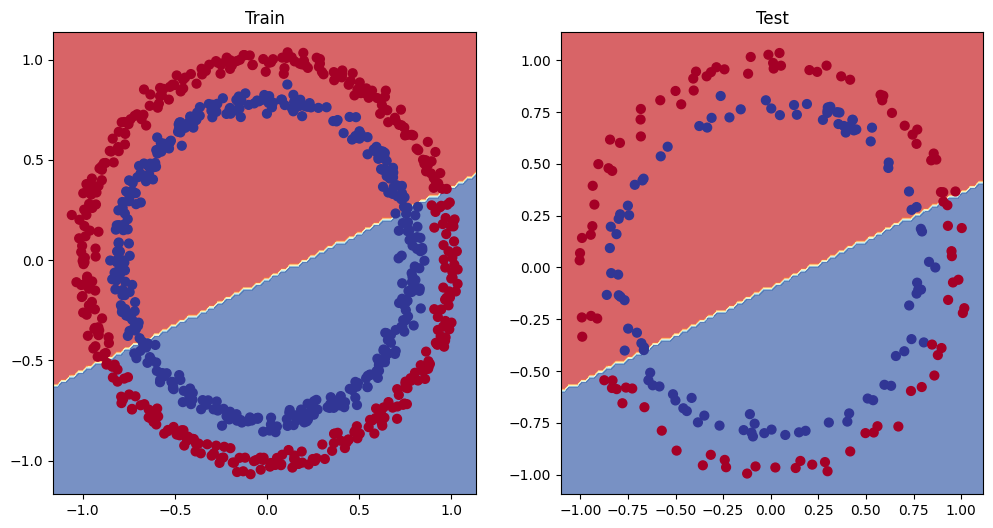

In [33]:
# Plot decision boundary of the model
def plotDB(model_0):
  plt.figure(figsize = (12, 6))
  plt.subplot(1, 2, 1)
  plt.title("Train")
  plot_decision_boundary(model_0, X_train, y_train)
  plt.subplot(1, 2, 2)
  plt.title("Test")
  plot_decision_boundary(model_0, X_test, y_test)

plotDB(model_0)

## 5. Improving a model (from a model perspective)

* Add more layers
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

Epoch: 0 | Loss: 0.69396 | Acc: 50.88 | Test loss: 0.69261 | Test acc: 50.88
Epoch: 100 | Loss: 0.69305 | Acc: 50.38 | Test loss: 0.69379 | Test acc: 50.38
Epoch: 200 | Loss: 0.69299 | Acc: 51.12 | Test loss: 0.69437 | Test acc: 51.12
Epoch: 300 | Loss: 0.69298 | Acc: 51.62 | Test loss: 0.69458 | Test acc: 51.62
Epoch: 400 | Loss: 0.69298 | Acc: 51.12 | Test loss: 0.69465 | Test acc: 51.12
Epoch: 500 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69467 | Test acc: 51.00
Epoch: 600 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69468 | Test acc: 51.00
Epoch: 700 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69468 | Test acc: 51.00
Epoch: 800 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69468 | Test acc: 51.00
Epoch: 900 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69468 | Test acc: 51.00
Epoch: 1000 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69468 | Test acc: 51.00


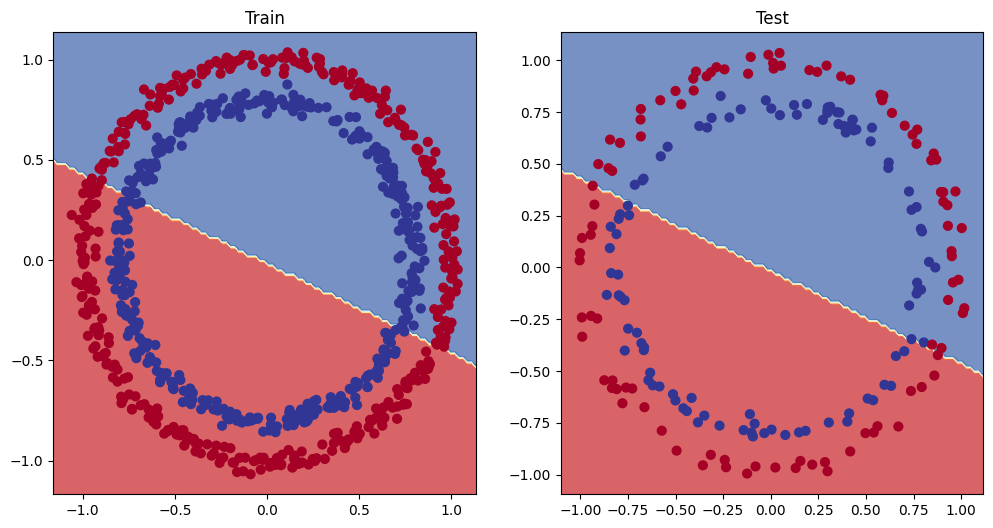

In [34]:
# Create a new model
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

  # Forward pass
  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1()
model_1.to(device)

# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer function
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

# Training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1001

# Put data on the target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Loop
for epoch in range(epochs):
  
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimzier step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()

  # 1. Forward pass
  test_logits = model_1(X_test).squeeze()
  test_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  test_loss = loss_fn(test_logits, y_test)
  test_acc = accuracy_fn(y_train, test_pred)

  # Print what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

# Plot the division boundary
plotDB(model_1)

Trying data from the `01_pytorch_workflow_fundamentals` - `Y = a + bX`

### 5.1 Preparing data to see if our model can fit a straight line 

In [35]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim = 1)
y_regression = weight * X_regression + bias 

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [36]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

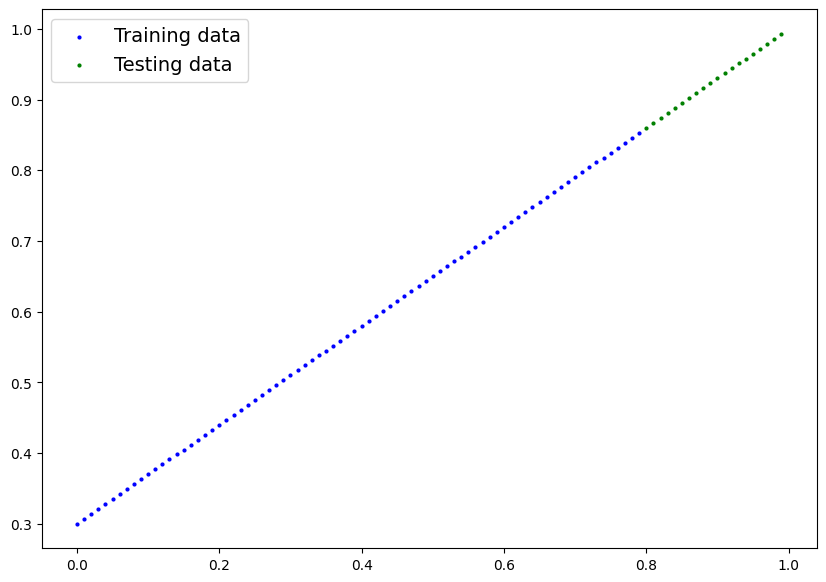

In [37]:
plot_predictions(train_data = X_train_regression, 
                 train_labels = y_train_regression, 
                 test_data = X_test_regression, test_labels = y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [38]:
model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.01)

# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1001

# Put the data on the target device
X_train_regression, y_train_regression, X_test_regression, y_test_regression = X_train_regression.to(device), y_train_regression.to(device), X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  # Training
  y_pred_regression = model_2(X_train_regression)
  loss = loss_fn(y_pred_regression, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360
Epoch: 1000 | Loss: 0.01782 | Test loss: 0.00333


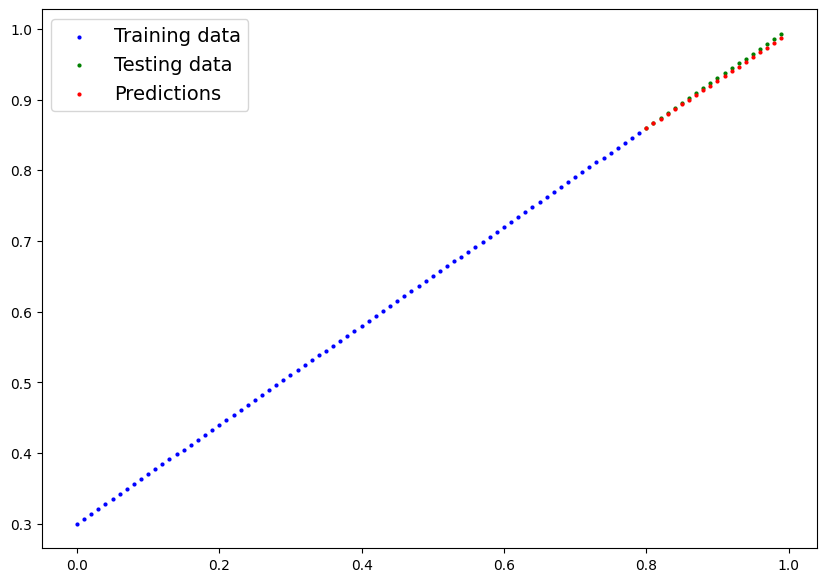

In [40]:
model_2.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot the predictions
plot_predictions(train_data = X_train_regression.cpu(), 
                 train_labels = y_train_regression.cpu(), 
                 test_data = X_test_regression.cpu(), 
                 test_labels = y_test_regression.cpu(),
                 predictions = y_preds.cpu())

## 6. The missing piece: non-linearity

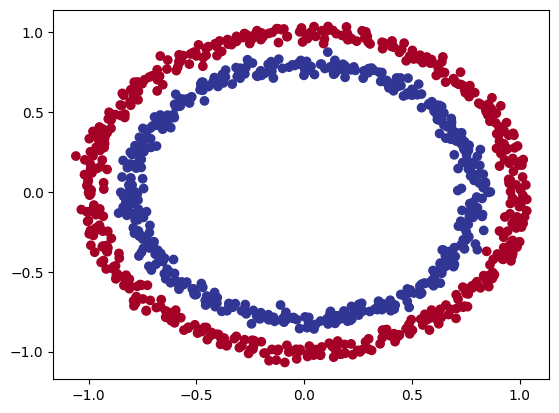

In [41]:
### 6.1 Recreating non-linear data(red and blue circles)

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.cm.RdYlBu)

In [42]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.1 Building a model with non-linearity

In [43]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 64)
    self.layer_2 = nn.Linear(in_features = 64, out_features = 64)
    self.layer_3 = nn.Linear(in_features = 64, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

### 6.2 Evaluating a model trained with non-linear 

In [44]:
model_3 = CircleModelV2()
model_3.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_3.parameters(), lr = 0.1)

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

epochs = 701

for epoch in range(epochs):
  # Training
  model_3.train()
  
  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
  
  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()
  
  # 4. Loss backwards
  loss.backward()
  
  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_3.eval()

  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) 
    
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69179 | Accuracy: 47.38% | Test loss: 0.69427 | Test acc: 46.50%
Epoch: 100 | Loss: 0.67966 | Accuracy: 63.50% | Test loss: 0.68497 | Test acc: 56.00%
Epoch: 200 | Loss: 0.66168 | Accuracy: 78.00% | Test loss: 0.67067 | Test acc: 71.00%
Epoch: 300 | Loss: 0.62306 | Accuracy: 90.88% | Test loss: 0.63723 | Test acc: 89.50%
Epoch: 400 | Loss: 0.53367 | Accuracy: 99.00% | Test loss: 0.55896 | Test acc: 98.00%
Epoch: 500 | Loss: 0.37491 | Accuracy: 99.75% | Test loss: 0.41442 | Test acc: 98.50%
Epoch: 600 | Loss: 0.21174 | Accuracy: 100.00% | Test loss: 0.25405 | Test acc: 99.50%
Epoch: 700 | Loss: 0.12633 | Accuracy: 100.00% | Test loss: 0.16374 | Test acc: 100.00%


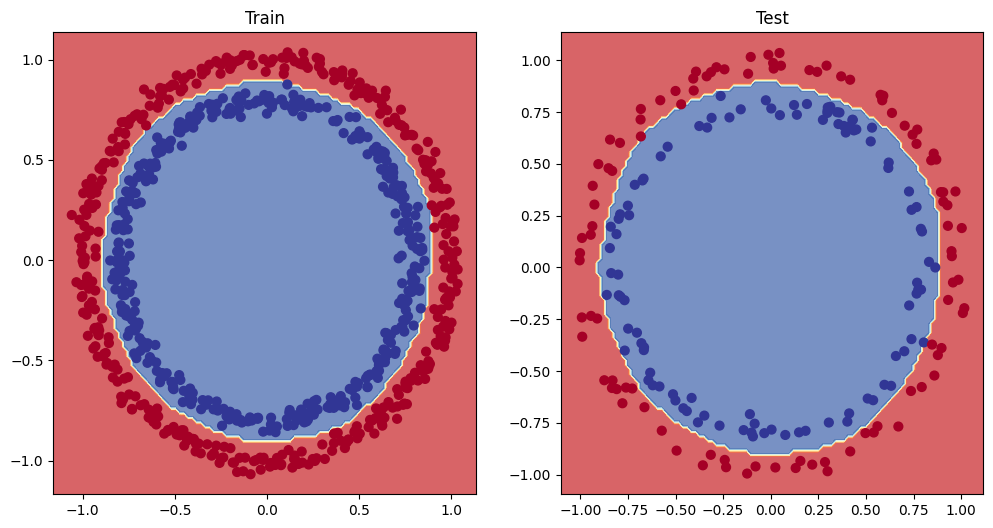

In [45]:
# Plot decision boundaries
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [46]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)

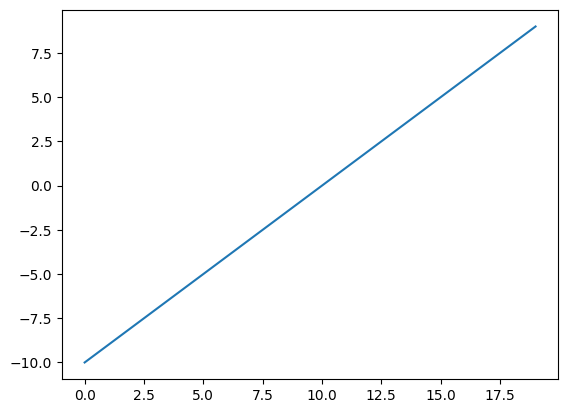

In [47]:
# Visualize the tensor
plt.plot(A);

ReLU

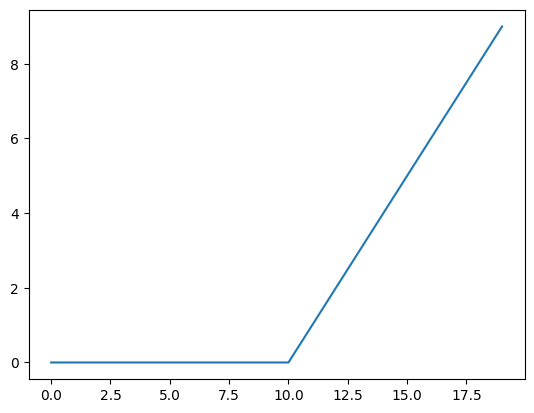

In [48]:
plt.plot(torch.relu(A));

In [49]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

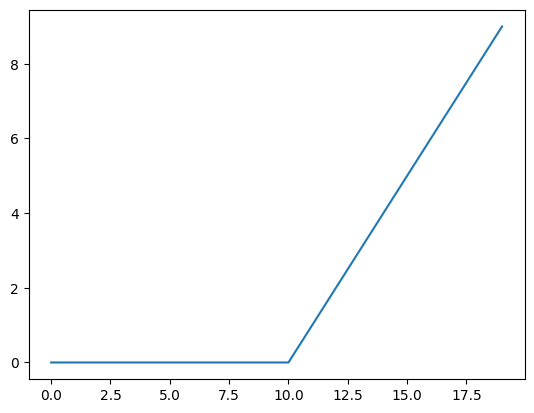

In [50]:
plt.plot(relu(A));

Sigmoid

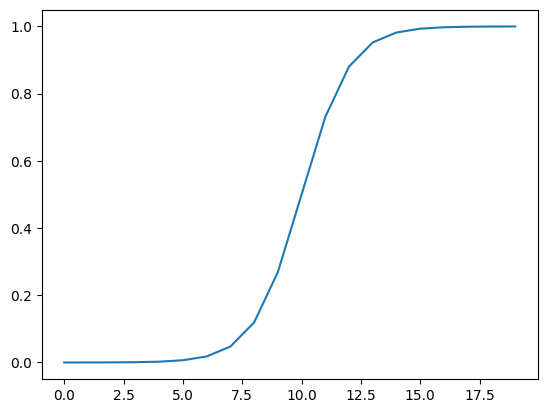

In [51]:
plt.plot(torch.sigmoid(A));

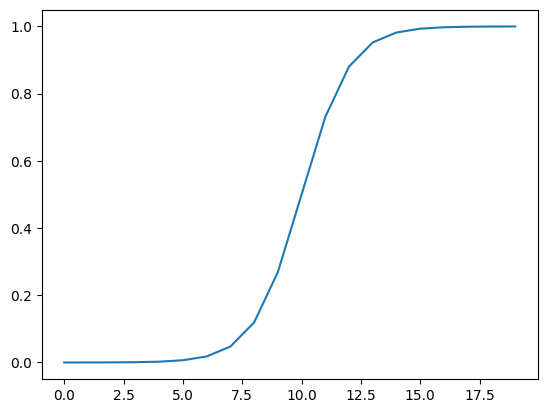

In [52]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A));

## 8. Multi-class classification

### 8.1 Creating a toy multi-class dataset

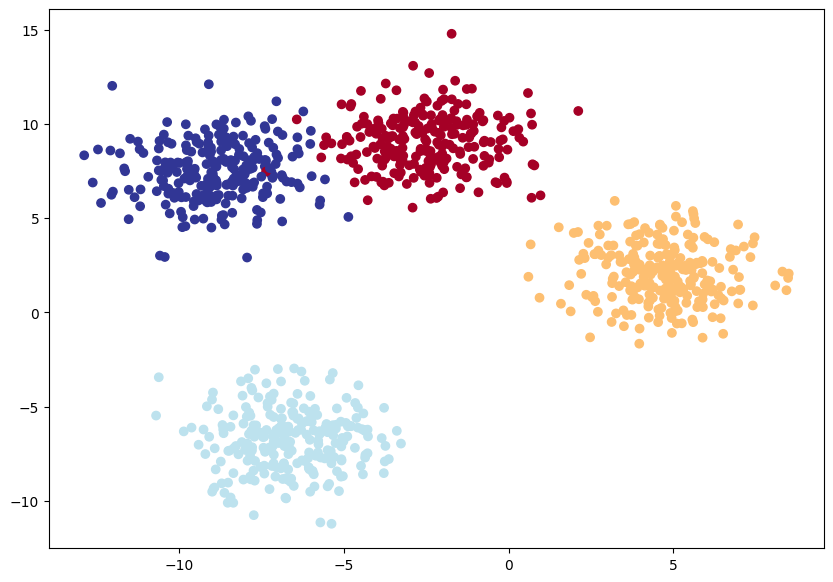

In [53]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000, 
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, 
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size = 0.2, 
                                                                        random_state = RANDOM_SEED)

# 4. Plot data 
plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap = plt.cm.RdYlBu);

### 8.2 Building the model

In [54]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [55]:
# Build the model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features = 2, 
                    output_features = 4).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [56]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [57]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimizer

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_4.parameters(), 
                            lr = 0.1)

### 8.4 Getting prediction probabilities for a multi-class

In [59]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:5]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])

In [60]:
y_pred_probs = torch.softmax(y_logits, dim = 1)

y_pred_probs[:5]

tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])

In [61]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [62]:
torch.argmax(y_pred_probs[0])

tensor(3)

In [63]:
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds[:10]

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3])

In [64]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

### 8.5 Training and testing loop

In [65]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_blob_train, y_blob_train, X_blob_test, y_blob_test = X_blob_train.to(device), y_blob_train.to(device), X_blob_test.to(device), y_blob_test.to(device)

epochs = 101

for epoch in range(epochs):

  # Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred  = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test loss: {test_loss:.4f} | Tess acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.0432 | Acc: 65.50% | Test loss: 0.5786 | Tess acc: 95.50%
Epoch: 10 | Loss: 0.1440 | Acc: 99.12% | Test loss: 0.1304 | Tess acc: 99.00%
Epoch: 20 | Loss: 0.0806 | Acc: 99.12% | Test loss: 0.0722 | Tess acc: 99.50%
Epoch: 30 | Loss: 0.0592 | Acc: 99.12% | Test loss: 0.0513 | Tess acc: 99.50%
Epoch: 40 | Loss: 0.0489 | Acc: 99.00% | Test loss: 0.0410 | Tess acc: 99.50%
Epoch: 50 | Loss: 0.0429 | Acc: 99.00% | Test loss: 0.0349 | Tess acc: 99.50%
Epoch: 60 | Loss: 0.0391 | Acc: 99.00% | Test loss: 0.0308 | Tess acc: 99.50%
Epoch: 70 | Loss: 0.0364 | Acc: 99.00% | Test loss: 0.0280 | Tess acc: 99.50%
Epoch: 80 | Loss: 0.0345 | Acc: 99.00% | Test loss: 0.0259 | Tess acc: 99.50%
Epoch: 90 | Loss: 0.0330 | Acc: 99.12% | Test loss: 0.0242 | Tess acc: 99.50%
Epoch: 100 | Loss: 0.0318 | Acc: 99.12% | Test loss: 0.0229 | Tess acc: 99.50%


### 8.6 Evaluating predictions

In [66]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

print(y_preds == y_blob_test)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

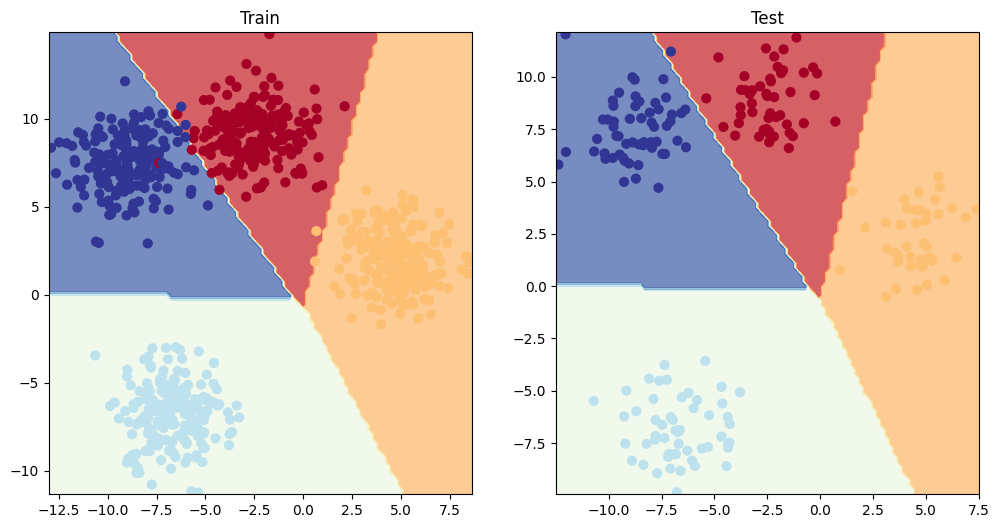

In [67]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics

* Accuracy
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [68]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.4 MB/s eta 0:00:00


In [69]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task="multiclass", num_classes = 4).to(device)

torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)